In [1]:
import sys, os
sys.path.append(os.path.abspath(
    os.getcwd()+"/core")
)

In [2]:
from core.quantum_error_correction_code import SurfaceCode, deformation_cmap
from core.neural_network import CNNDual, CNN, load_params, save_params

from core.replay_buffer import UniformReplayBuffer
from core.agent import DQN

from core.environment import *

import jax.numpy as jnp
from jax import random, lax
from jax.tree_util import tree_map
import optax

import matplotlib.pyplot as plt
from time import time

# Hyper parameters

Number of shots per estimated error rate:  1,000,000


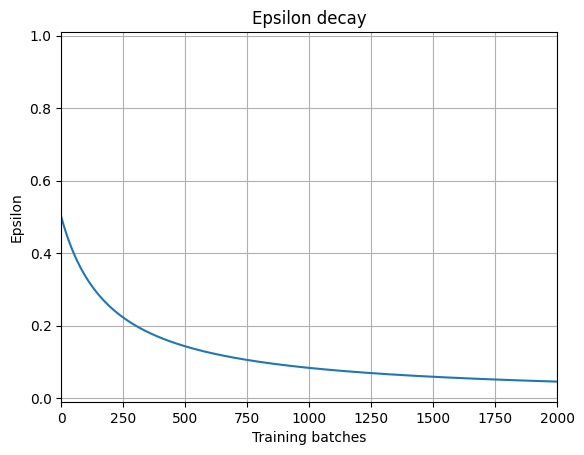

In [3]:
TRAINING_BATCHES = 2_000

CODE_DISTANCE = 3
EPISODE_LENGTH = 3*CODE_DISTANCE**2 # Set to -1 to disable

INIT_LEARNING_RATE = 0
LEARNING_RATE = 1E-3
WARMUP_STEPS = 100
TRANSITION_STEP = 100
DECAY_RATE = 0.8

SEED = 362

ENVIRONMENT_TYPE = "PML" # PML or CNN-G
AGENT_CONV_LAYERS = [(12,3,1,1), (18,3,1,1), (12,3,1,1), (6,3,1,1)]

# Training baches are low enough to all be stored in the buffer
BUFFER_SIZE = TRAINING_BATCHES
BATCH_SIZE = 32

DISCOUNT_FACTOR = 0.8
TARGET_NET_UPDATE_RATE = 0.1

# Having the num of estimation samples be as small as possible will result in a faster training time
# but will also use of more memory. So it is not always possible to have a sample count of 1
NUM_ESTIMATION_SAMPLES = 100
ESTIMATION_SAMPLE_SIZE = 10_000
print("Number of shots per estimated error rate: ", f"{ESTIMATION_SAMPLE_SIZE * NUM_ESTIMATION_SAMPLES:,}")

epsilon_scaling_option = 1 # 0: exploration, 1: decay, 2: exploitation
if epsilon_scaling_option == 0:
    # 100% exploration
    EPSILON_START = 1.0
    EPSILON_END = 1.0
    EPSILON_DECAY_RATE = 1.0
    scaling_name = "exploration"
elif epsilon_scaling_option == 1:
    # 50% decaying to 0% exploitation
    EPSILON_START = 0.5
    EPSILON_END = 0.0
    EPSILON_DECAY_RATE = 0.005
    scaling_name = "decay"
elif epsilon_scaling_option == 2:
    # 0% exploitation
    EPSILON_START = 0.0
    EPSILON_END = 0.0
    EPSILON_DECAY_RATE = 1.0
    scaling_name = "exploitation"
else:
    raise ValueError("Invalid epsilon scaling option")

# Epsilon scaling
def inverse_scaling_decay(epsilon_start, epsilon_end, current_step, decay_rate):
    return epsilon_end + (epsilon_start - epsilon_end) / (1 + decay_rate * current_step)

x_ = jnp.linspace(0, TRAINING_BATCHES, 1000)
y_ = inverse_scaling_decay(EPSILON_START, EPSILON_END, x_, EPSILON_DECAY_RATE)
plt.plot(x_, y_)
plt.title("Epsilon decay")
plt.xlabel("Training batches")
plt.ylabel("Epsilon")
plt.grid()
plt.ylim(-0.01, 1.01)
plt.xlim(0, TRAINING_BATCHES)
plt.show()

In [4]:
save_data = True

NAME = f"RL-{ENVIRONMENT_TYPE}-{CODE_DISTANCE}-{scaling_name}"
NAME += "_with_periodic-reset" if EPISODE_LENGTH != -1 else ""

print(NAME)

RL-PML-3-decay_with_periodic-reset


# Initialize the code

In [5]:
key = random.key(126)

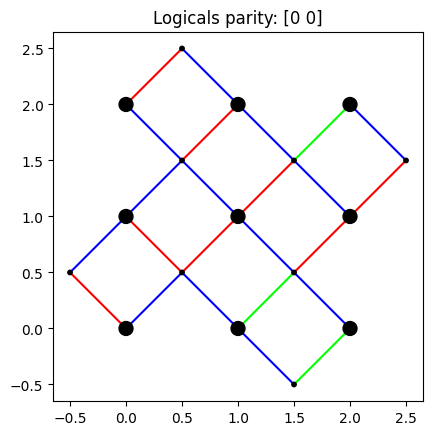

In [6]:
code = SurfaceCode(CODE_DISTANCE)
deformation, key = code.random_deformation(key, allowed_deformations=jnp.arange(6))
parity_info = code.deformation_parity_info(deformation)
code.show(parity_info)

# Optimizer

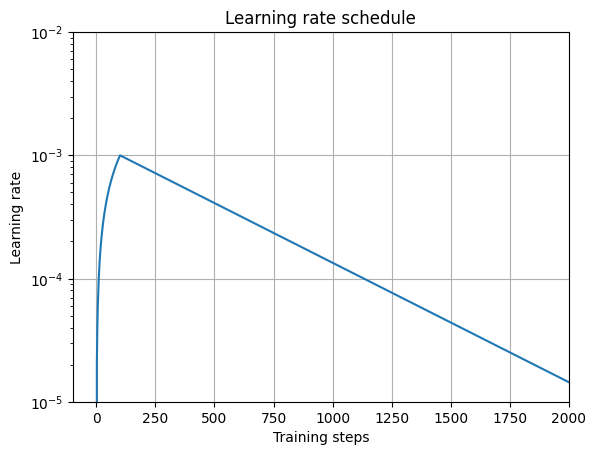

In [7]:
learning_rate = optax.warmup_exponential_decay_schedule(
    init_value=INIT_LEARNING_RATE,
    peak_value=LEARNING_RATE,
    warmup_steps=WARMUP_STEPS,
    transition_steps=TRANSITION_STEP,
    decay_rate=DECAY_RATE
)

step = jnp.linspace(0, TRAINING_BATCHES, 1000)

plt.figure()
plt.plot(step, learning_rate(step))
plt.yscale('log')
plt.title("Learning rate schedule")
plt.xlabel("Training steps")
plt.ylabel("Learning rate")
plt.grid()
plt.xlim(xmax=TRAINING_BATCHES)
plt.ylim(1E-5, 1E-2)
plt.show()

optimizer = optax.adam(learning_rate)

# Load a decoder

In [8]:
settings, decoder_params = load_params(f"data/CNN-G-{CODE_DISTANCE}.json")

# Replay buffer

In [9]:
replay_buffer = UniformReplayBuffer(
    buffer_size=BUFFER_SIZE,
    batch_size=BATCH_SIZE,
    num_qubits=CODE_DISTANCE**2
)
buffer_state = replay_buffer.empty_buffer()

# Agent

In [10]:
class AgentModel(CNN):

    def __init__(self, input_shape, conv_layers):
        super().__init__(input_shape, conv_layers)

    def apply_single(
        self,
        params: list[dict[str, jnp.ndarray]],
        x: jnp.ndarray,
    ) -> jnp.ndarray:
        """Applies the CNN to a batch of input x."""
        return super().apply_single(
            params,
            code.deformation_image(x)
        )

agent_model = AgentModel(
    input_shape=(6, CODE_DISTANCE, CODE_DISTANCE),
    conv_layers=AGENT_CONV_LAYERS
)
display(agent_model.layer_sizes)

agent = DQN(
    model=agent_model,
    discount=DISCOUNT_FACTOR,
    num_data_qubits=CODE_DISTANCE*CODE_DISTANCE
)

[(6, 3, 3), (12, 3, 3), (18, 3, 3), (12, 3, 3), (6, 3, 3)]

In [11]:
[(6, 'L', 'L'), (12, 'L', 'L'), (18, 'L', 'L'), (12, 'L', 'L'), (6, 'L', 'L')]

[(6, 'L', 'L'), (12, 'L', 'L'), (18, 'L', 'L'), (12, 'L', 'L'), (6, 'L', 'L')]

# Environment

In [12]:
if ENVIRONMENT_TYPE == "CNN-G":
    decoder_model = CNNDual(
        input_shape_1 = (1, CODE_DISTANCE+1, CODE_DISTANCE+1),
        input_shape_2 = (6, CODE_DISTANCE, CODE_DISTANCE),
        conv_layers_input_1=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_INPUT_1"]],
        conv_layers_input_2=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_INPUT_2"]],
        conv_layers_stage_2=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_STAGE_2"]],
        fc_layers=[int(v) for v in settings["FC_LAYERS"]],
    )
    display(decoder_model.layer_sizes)

    env = EnvironmentCNN(
        model=decoder_model,
        model_params=decoder_params,
        noise_model=settings["ERROR_PROBS"],
        code=code,
        num_samples=NUM_ESTIMATION_SAMPLES,
        sample_size=ESTIMATION_SAMPLE_SIZE,
    )
elif ENVIRONMENT_TYPE == "PML":
    # Impractival beyond distance 3 surface codes
    env = EnvironmentPML(
        noise_model=settings["ERROR_PROBS"],
        code=code,
    )
else:
    raise ValueError(f"No environment of type \"{ENVIRONMENT_TYPE}\" found")

if CODE_DISTANCE == 3:
    all_logical_error_rates_truth = jnp.load("data/environmentCNN_CNN-G_error_rates_p01_nu500.npy")
    equivalence_mapper = lambda d: jnp.array([0,0,2,3,3,2])[d]
    env_truth = EnvironmentLookup(
        lookup_table=all_logical_error_rates_truth,
        num_of_deformations=3,
        code=code,
        equivalence_mapper=equivalence_mapper
    )
else:
    all_logical_error_rates_truth = jnp.array(jnp.nan)

print(ENVIRONMENT_TYPE)

PML


# Train the RL-agent

In [13]:
def train(
    timesteps: int,
    random_seed: int,
    tau: float,
    model: CNN,
    optimizer: optax.GradientTransformation,
    buffer_state: dict,
    buffer_size: int,
    agent: DQN,
    env: EnvironmentBase,
    replay_buffer: UniformReplayBuffer,
    epsilon_decay_fn,
    epsilon_start: float,
    epsilon_end: float,
    decay_rate: float,
):
    """
    Train the RL-agent to find the best deformation of the given size surface code
    """

    def _fori_body(
        i: int,
        val: tuple
    ):
        """
        Performs a single step of training
        """

        (
            online_net_params,
            target_net_params,
            deformation,
            deformations,
            score,
            scores,
            rewards,
            error_rates,
            done,
            dones,
            opt_state,
            buffer_state,
            act_key,
            env_key,
            sample_key,
            losses,
        ) = val

        # Calculate the q-value if we stay put in the current state
        inactive_q_value = score / (1 + DISCOUNT_FACTOR) # sum s*gamma^n, n=0 to infinity
        
        # Let agent pick a deformation action
        action, done, act_key = agent.act(
            act_key,
            online_net_params,
            deformation,
            epsilon = epsilon_decay_fn(epsilon_start, epsilon_end, i, decay_rate),
            inactive_q_value=inactive_q_value,
        )
        deformation_action_idx, data_qubit_action_idx = agent.split_action(action)

        # If done don't change the state
        deformation_action_idx, data_qubit_action_idx, done = lax.cond(
            done,
            lambda: (deformation[0], 0, True),
            lambda: (deformation_action_idx, data_qubit_action_idx, done)
        )

        # Update the deformation
        new_deformation = deformation.at[data_qubit_action_idx].set(deformation_action_idx)

        # Calculate the agents reward
        reward, new_score, error_rate, env_key = env.reward(
            env_key,
            score,
            new_deformation,
        )
        # # Only reward at the end of the episode
        # reward, done = lax.cond(
        #     i % EPISODE_LENGTH == 0,
        #     # If the episode is over, reward the agent
        #     lambda: (jnp.log10(new_score), True),
        #     # If the episode is not over, do not reward the agent
        #     lambda: (0.0, False),
        # )

        # Add the current experience to the buffer
        experience = (deformation, score, action, reward, new_deformation, done)
        buffer_state = replay_buffer.add(
            buffer_state,
            experience,
            idx=i
        )

        # Update the agent
        experiences, sample_key = replay_buffer.sample(
            sample_key,
            buffer_state,
            jnp.min(jnp.array([i, buffer_size]))
        )
        online_net_params, opt_state, loss = agent.update(
            online_net_params,
            target_net_params,
            optimizer,
            opt_state,
            experiences,
        )

        # update the target parameters to be tau closer to the online parameters
        target_net_params = tree_map(
            lambda target, online: (1 - tau) * target + tau * online, 
            target_net_params, 
            online_net_params
        )

        # Update the variables
        deformation = new_deformation
        score = new_score

        if EPISODE_LENGTH != -1:
            # Reset the environment if the episode is over
            done, deformation, score, error_rate, env_key = lax.cond(
                i % EPISODE_LENGTH == 0,
                # Reset the environment
                lambda: (False, *env.reset(env_key, to_random_state=False)),
                # Continue with the current deformation
                lambda: (done, deformation, score, error_rate, env_key),
            )

        # Update tracked information
        rewards = rewards.at[i].set(reward)
        losses = losses.at[i].set(loss)
        deformations = deformations.at[i].set(deformation)
        scores = scores.at[i].set(score)
        dones = dones.at[i].set(done)
        error_rates = error_rates.at[i].set(error_rate)

        return (
            online_net_params,
            target_net_params,
            deformation,
            deformations,
            score,
            scores,
            rewards,
            error_rates,
            done,
            dones,
            opt_state,
            buffer_state,
            act_key,
            env_key,
            sample_key,
            losses,
        )
    
    act_key, sample_key, env_key, init_online_key, init_target_key = random.split(
        random.key(random_seed), num=5
    )

    target_net_params = model.init(init_target_key)
    online_net_params = model.init(init_online_key)

    deformation, score, error_rate, env_key = env.reset(env_key)
    done = False

    opt_state = optimizer.init(online_net_params)

    losses = jnp.empty(timesteps, dtype=jnp.float32)
    rewards = jnp.empty(timesteps, dtype=jnp.float32)
    scores = jnp.empty(timesteps, dtype=jnp.float32)
    error_rates = jnp.empty(timesteps, dtype=jnp.float32)
    dones = jnp.zeros(timesteps, dtype=jnp.bool)
    deformations = jnp.empty((timesteps, agent.num_data_qubits), dtype=jnp.int32)

    val_init = (
        online_net_params,
        target_net_params,
        deformation,
        deformations,
        score,
        scores,
        rewards,
        error_rates,
        done,
        dones,
        opt_state,
        buffer_state,
        act_key,
        env_key,
        sample_key,
        losses,
    )

    # vals = _fori_body(0, val_init)
    vals = lax.fori_loop(0, TRAINING_BATCHES, _fori_body, val_init)

    return vals

In [14]:
t0 = time()
(
    online_net_params,
    target_net_params,
    deformation,
    deformations,
    score,
    scores,
    rewards,
    error_rates,
    done,
    dones,
    opt_state,
    buffer_state,
    act_key,
    env_key,
    sample_key,
    losses,
) = train(
    timesteps = TRAINING_BATCHES,
    random_seed = SEED,
    tau = TARGET_NET_UPDATE_RATE,
    model = agent_model,
    optimizer = optimizer,
    buffer_state = buffer_state,
    buffer_size = BUFFER_SIZE,
    agent = agent,
    env = env,
    replay_buffer = replay_buffer,
    epsilon_decay_fn = inverse_scaling_decay,
    epsilon_start = EPSILON_START,
    epsilon_end = EPSILON_END,
    decay_rate = EPSILON_DECAY_RATE,
)

print(deformation)

if save_data:
    save_params(
        online_net_params,
        {
            # Training results
            "deformations": deformations,
            "scores": scores,
            "rewards": rewards,
            "dones": dones,
            "losses": losses,
            # Hyperparameters
            "TRAINING_BATCHES": TRAINING_BATCHES,
            "BUFFER_SIZE": BUFFER_SIZE,
            "BATCH_SIZE": BATCH_SIZE,
            "NUM_ESTIMATION_SAMPLES": NUM_ESTIMATION_SAMPLES,
            "ESTIMATION_SAMPLE_SIZE": ESTIMATION_SAMPLE_SIZE,
            "TOTAL_SHOTS": NUM_ESTIMATION_SAMPLES * ESTIMATION_SAMPLE_SIZE,
            "SEED": SEED,
            "DISCOUNT_FACTOR": DISCOUNT_FACTOR,
            "EPSILON_START": EPSILON_START,
            "EPSILON_END": EPSILON_END,
            "EPSILON_DECAY_RATE": EPSILON_DECAY_RATE,
        },
        f"data/{NAME}.json"
    )

training_time = time() - t0
print(f"{int(training_time/60/60):5d}h {int(training_time/60%60):02d}m {int(training_time%60):02d}s", end='\r')

[0 0 0 0 0 3 0 0 0]


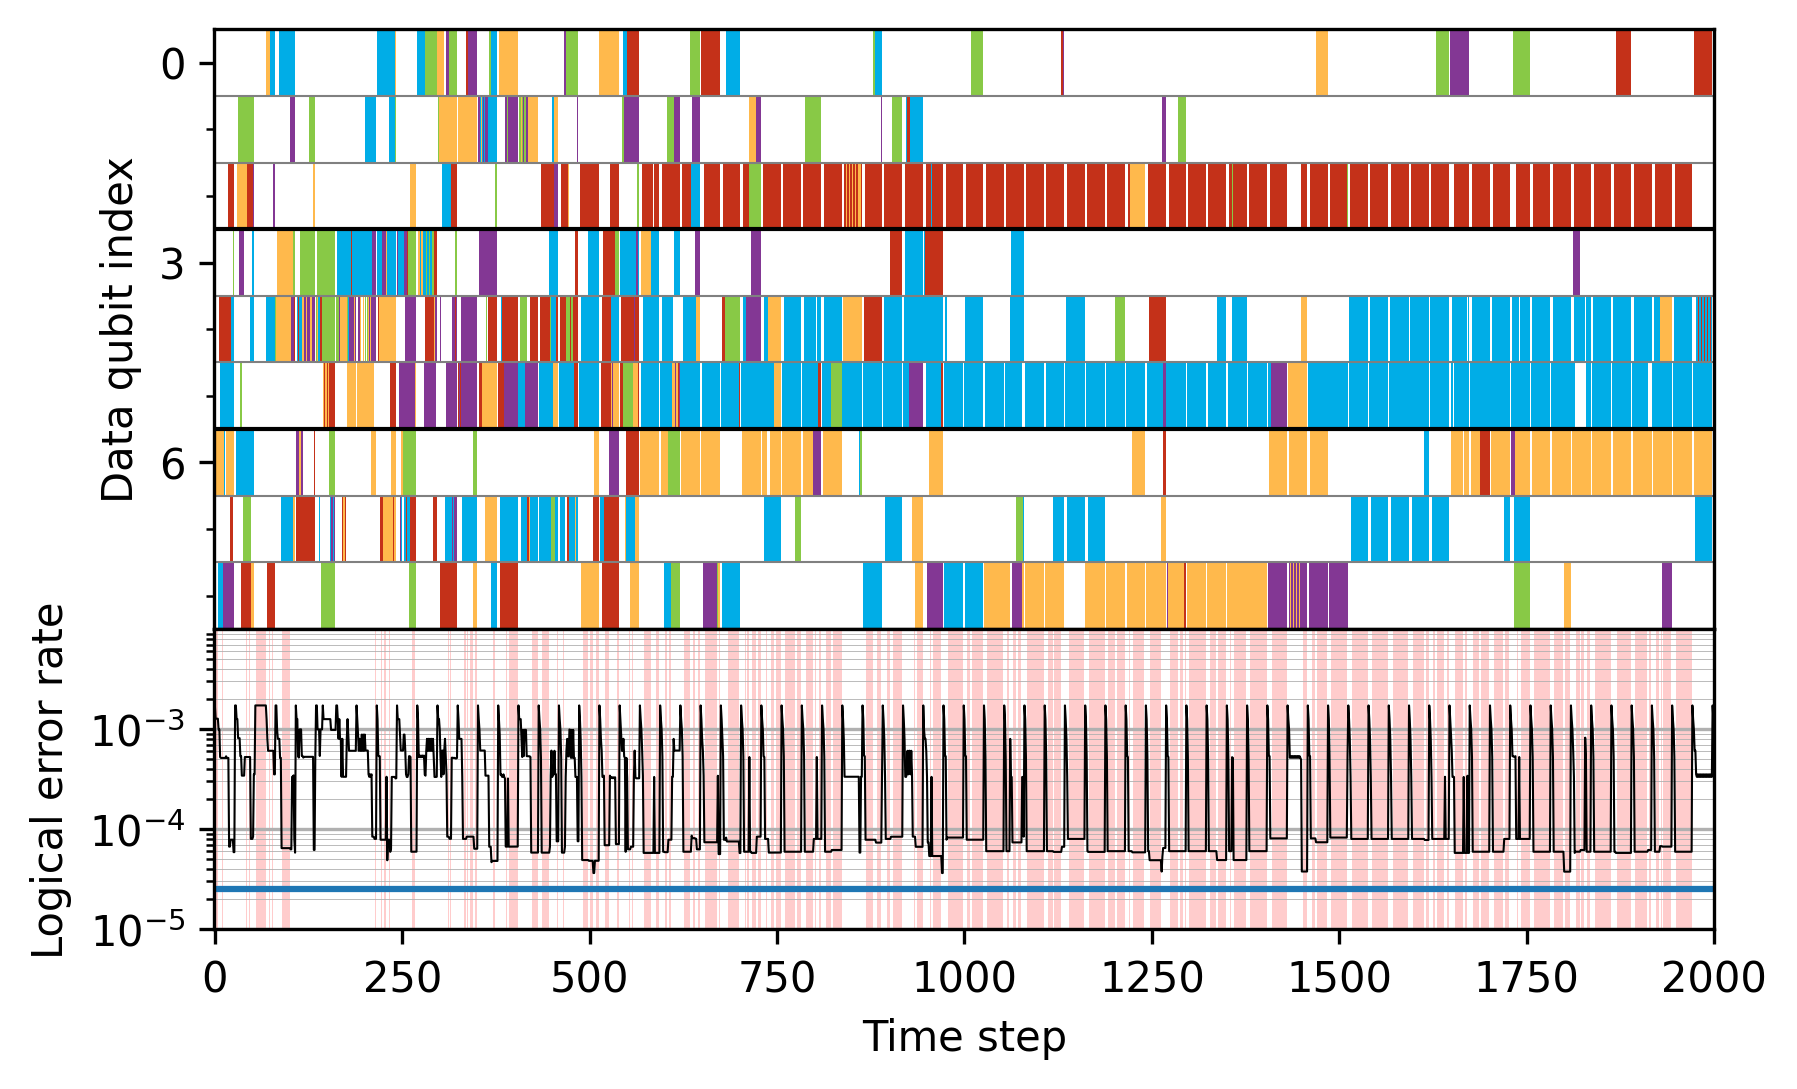

In [15]:
# Log avarage error rate
running_avg_error_rate = jnp.exp(jnp.convolve(jnp.log(error_rates), jnp.ones(2*EPISODE_LENGTH)/EPISODE_LENGTH/2, mode='valid'))

fig = plt.figure(dpi=300, figsize=(5,2))

im_aspect = TRAINING_BATCHES / deformations.shape[1]
fig_aspect = fig.get_figheight() / fig.get_figwidth()

ax = fig.add_axes((0,0,1,1))
im = ax.imshow(deformations.T, aspect=im_aspect*fig_aspect, interpolation="nearest", cmap=deformation_cmap, vmin=-.5, vmax=5.5)
ax.set_ylabel("Data qubit index")
ax.set_xlim(-.5, TRAINING_BATCHES+.5)
ax.set_xticks([])
ax.set_yticks(jnp.arange(0, deformations.shape[1], CODE_DISTANCE))
ax.set_yticks(jnp.arange(0, deformations.shape[1]), minor=True)
ax.set_yticklabels(jnp.arange(0, deformations.shape[1], CODE_DISTANCE))
ax.hlines(jnp.arange(CODE_DISTANCE**2)[1:]-.5, [-1]*(CODE_DISTANCE**2-1), [error_rates.shape[0]]*(CODE_DISTANCE**2-1), color='gray', lw=.5)
ax.hlines(CODE_DISTANCE*jnp.arange(CODE_DISTANCE)[1:]-.5, [-1]*(CODE_DISTANCE-1), [error_rates.shape[0]]*(CODE_DISTANCE-1), color='k', lw=1)
# for i in range(0, TRAINING_BATCHES, EPISODE_LENGTH):
#     ax.axvline(i, color='blue', linestyle='--', lw=0.5)

ax = fig.add_axes((0,-.5,1,.5))
ax.plot(range(error_rates.shape[0]), error_rates, '-k', lw=.5, ms=2)
# ax.plot(jnp.arange(len(running_avg_error_rate))+EPISODE_LENGTH, running_avg_error_rate, 'r--', lw=.5, label='Running Avg')
ax.set_xlim(-.5, error_rates.shape[0]+.5)
ax.set_yscale('log')
ax.set_ylim(10**jnp.floor(jnp.log10(error_rates.min())), 10**jnp.ceil(jnp.log10(error_rates.max())))
ax.set_ylabel("Logical error rate")
ax.grid(which='major', axis='y')
ax.grid(which='minor', lw=.2)
ax.set_xlabel("Time step")
ax.fill_between(
    range(error_rates.shape[0]),
    10**jnp.floor(jnp.log10(error_rates.min()))*jnp.ones(error_rates.shape[0]),
    10**jnp.ceil(jnp.log10(error_rates.max()))*jnp.ones(error_rates.shape[0]),
    color='red', alpha=.2,
    where=dones, lw=0,
)
# for i in range(0, TRAINING_BATCHES, EPISODE_LENGTH):
#     ax.axvline(i, color='blue', linestyle='--', lw=0.5)

plt.axhline(2.5E-5)

plt.show()

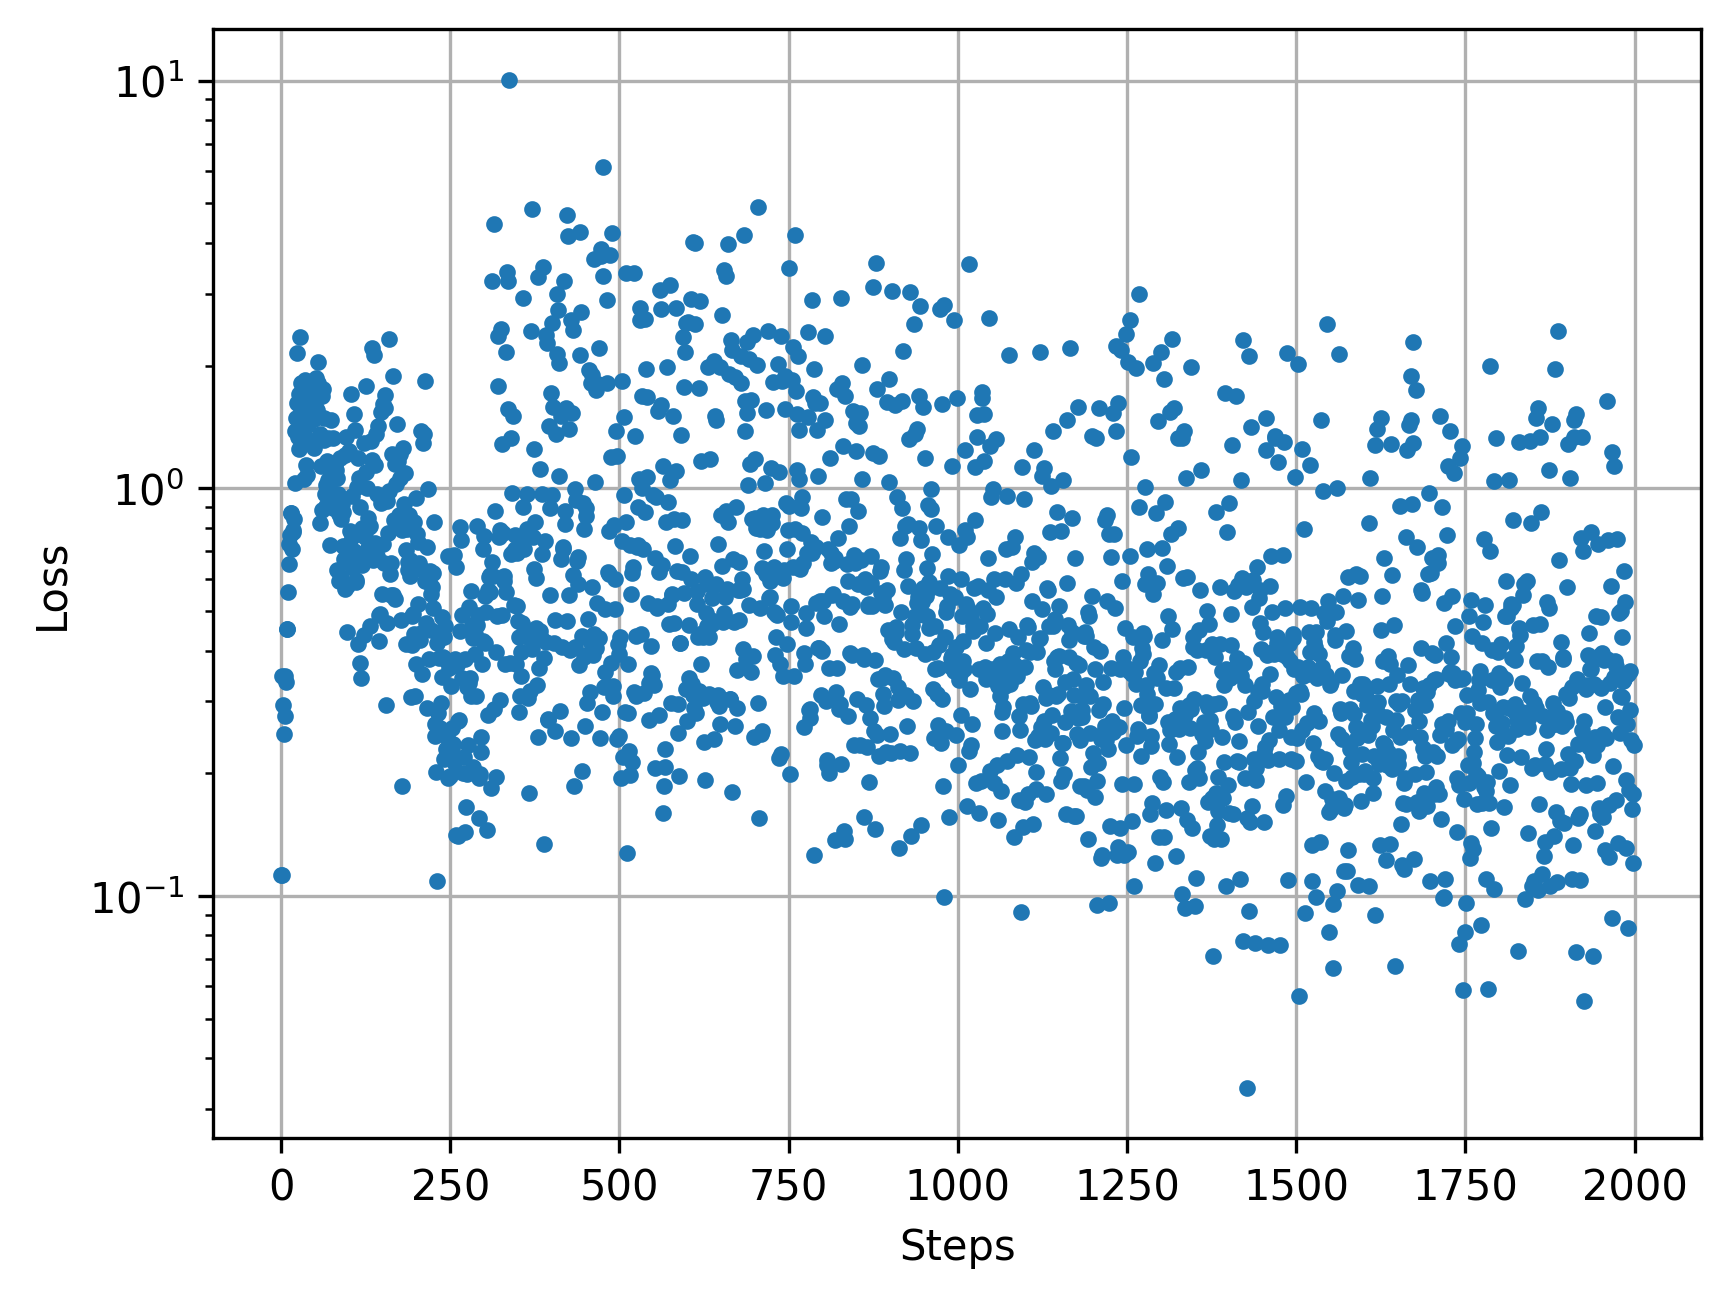

In [16]:
end = losses.shape[0]
plt.figure(dpi=300)
plt.plot(jnp.arange(end), losses, '.', lw=.5)
plt.grid()
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

In [17]:
key = random.key(SEED)
max_steps = 100

deformations_ = -jnp.ones((max_steps, agent.num_data_qubits), dtype=jnp.int32)
error_rates_ = jnp.empty((max_steps,), dtype=jnp.float32)

deformation_, score_, error_rate_, key = env.reset(key)
done_ = False

deformations_ = deformations_.at[0].set(deformation_)
error_rates_ = error_rates_.at[0].set(error_rate_)
for i in range(1, max_steps):
    action_, done_, key = agent.act(
        key,
        online_net_params,
        deformation_,
        epsilon=0.0
    )
    deformation_action_idx, data_qubit_action_idx = agent.split_action(action_)
    deformation_ = deformation_.at[data_qubit_action_idx].set(deformation_action_idx)
    reward_, score_, error_rate_, key = env.reward(
        key,
        score_,
        deformation_
    )

    if done_ or (deformations_ == deformation_[None,:]).all(axis=1).sum() > 5:
        break
    
    deformations_ = deformations_.at[i].set(deformation_)
    error_rates_ = error_rates_.at[i].set(error_rate_)
    print(f"Step {i+1}/{max_steps}: {deformation_action_idx} -> {deformation_}, reward: {reward_}, error rate: {error_rate_}", end='\r')

0.00028299997211433947

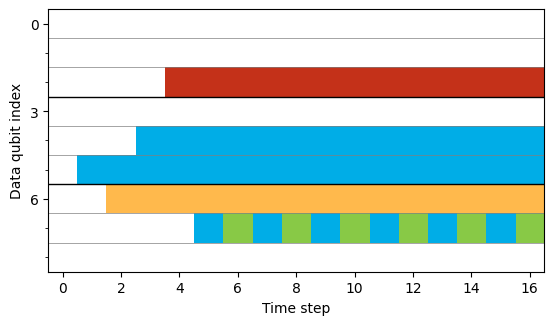

In [18]:
# plt.imshow(jnp.array([0,0,2,3,3,2])[deformations_[:i].T], interpolation="nearest", cmap=deformation_cmap, vmin=-.5, vmax=5.5)
plt.imshow(deformations_[:i].T, interpolation="nearest", cmap=deformation_cmap, vmin=-.5, vmax=5.5)
plt.xlabel("Time step")
plt.ylabel("Data qubit index")
plt.xlim(-.5, i-.5)
plt.yticks(jnp.arange(0, deformations_.shape[1], CODE_DISTANCE))
plt.yticks(jnp.arange(0, deformations_.shape[1]), minor=True)
plt.hlines(jnp.arange(CODE_DISTANCE**2)[1:]-.5, [-1]*(CODE_DISTANCE**2-1), [error_rates.shape[0]]*(CODE_DISTANCE**2-1), color='gray', lw=.5)
plt.hlines(CODE_DISTANCE*jnp.arange(CODE_DISTANCE)[1:]-.5, [-1]*(CODE_DISTANCE-1), [error_rates.shape[0]]*(CODE_DISTANCE-1), color='k', lw=1)
plt.show()